<a href="https://colab.research.google.com/github/ArpitJainZoomInfo/Test-Project3/blob/main/International_Pod_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# International Pod Segmentation Analysis

The purpose of this notebook is to create segments using clustering techniques for the international data pod. The following is a summary of what occurs in the table. Each section will also have its own write-up on what is occurring.

*   Data is Imported
*   Data Cleaning and Feature Engineering Occurs
*   Data Visualization
*   Numeric data to be analyzed using clustering is Standardized
*   PCA Occurs
*.  Analysis to determine the number of clusters
*.  Clustering
*.  Average Revenue per Cluster
*.  Cluster Summaries and Visualizations



In [ ]:
#Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()

The Data can be imported from a local drive or can be uploaded directly into the colab environment. Due to upload limits into Google Drive, I've limited the data sample to 1,000,000 rows.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading in the data that resulted from SQL Query
intl_data = pd.read_csv('/content/drive/Shareddrives/Data_POD_International/Segmentation/20231005/3 Combination.csv',usecols=["ACCOUNTID","COUNTRY","SUBINDUSTRY","INDUSTRY","REVENUE","HEADCOUNT","SEARCHED_MARKET_SEGMENT","CUSTOMER_STATUS","NAICS","LATITUDE","LONGITUDE","DEPARTMENT","TITLE","SEARCHED_COUNT","VIEWEDCOMPANYCARD_COUNT","EXPORT_COUNT","ACV",])


#Basic information about the table
intl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ACCOUNTID                1200000 non-null  object 
 1   COUNTRY                  1200000 non-null  object 
 2   SUBINDUSTRY              1190536 non-null  object 
 3   INDUSTRY                 1096538 non-null  object 
 4   REVENUE                  1199902 non-null  float64
 5   HEADCOUNT                1199950 non-null  float64
 6   SEARCHED_MARKET_SEGMENT  1199950 non-null  object 
 7   CUSTOMER_STATUS          1200000 non-null  object 
 8   NAICS                    1200000 non-null  int64  
 9   LATITUDE                 1037771 non-null  float64
 10  LONGITUDE                1037771 non-null  float64
 11  DEPARTMENT               1075900 non-null  object 
 12  TITLE                    1200000 non-null  object 
 13  ACV                      1200000 non-null 

Data cleaning consists of filling in Null values, dropping some rows with Null values, and feature engineering new columns.

Here industry is being replaced by its subindustry value when there is only one value found in the sub-industry.

The rows with department values that are null but have a C-Level are replace with 'C-Suite'

Null Department values with an industry of retail are replaced with 'Sales'

Making sure that Revenue is not NULL.

Then creating two definitions that will help with separating the 6-digit NAICS code into 5 columns (with the first two digits going into their own column).

In [ ]:
#Data Cleaning and Filling in Null values
#Replacing null industry values with subindustry values where possible
intl_data.loc[intl_data['INDUSTRY'].isnull(),'INDUSTRY'] = intl_data['SUBINDUSTRY']

#Replacing null department values with C-Suite value where the title of the row is C-Level
intl_data.loc[(intl_data['DEPARTMENT'].isnull()) & (intl_data['TITLE'] == 'C-Level'),['DEPARTMENT']] = 'C-Suite'

#Replacing Department Nulls with a Retail industry with sales
intl_data.loc[(intl_data['DEPARTMENT'].isnull()) & (intl_data['INDUSTRY'] == 'Retail'),['DEPARTMENT','INDUSTRY']] = 'Sales'

intl_data = intl_data[intl_data['REVENUE'].notna()]

#Seperating the NAICS digits and then concatting the first two digits back together
def digit(x, n):
    """Return the n-th digit of integer in base 10"""
    return (x // 10**n) % 10

def digitize(df, key, n):
    """Extract n less significant digits from an integer in base 10"""
    for i in range(n):
        df['x%d' % i] = digit(df[key], n-i-1)

#Apply function on dataframe (inplace):
digitize(intl_data, 'NAICS',6)

#Concatting first two NAICS digits
intl_data['x0_x1'] = intl_data.x0 + intl_data.x1
intl_data = intl_data.drop(['NAICS','x0','x1'], axis=1)
intl_data = intl_data[intl_data['LATITUDE'].notna()]

intl_data.info()

<ipython-input-6-15423218a25a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x%d' % i] = digit(df[key], n-i-1)
<ipython-input-6-15423218a25a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x%d' % i] = digit(df[key], n-i-1)
<ipython-input-6-15423218a25a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037717 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ACCOUNTID                1037717 non-null  object 
 1   COUNTRY                  1037717 non-null  object 
 2   SUBINDUSTRY              1030967 non-null  object 
 3   INDUSTRY                 1030967 non-null  object 
 4   REVENUE                  1037717 non-null  float64
 5   HEADCOUNT                1037717 non-null  float64
 6   SEARCHED_MARKET_SEGMENT  1037717 non-null  object 
 7   CUSTOMER_STATUS          1037717 non-null  object 
 8   LATITUDE                 1037717 non-null  float64
 9   LONGITUDE                1037717 non-null  float64
 10  DEPARTMENT               952335 non-null   object 
 11  TITLE                    1037717 non-null  object 
 12  ACV                      1037717 non-null  float64
 13  SEARCHED_COUNT           1037717 non-null 

### Graph Visualization

I think these initial graph visualizations make sense. We are visualizing the distributions for countries, industries, and titles across the whole dataset.

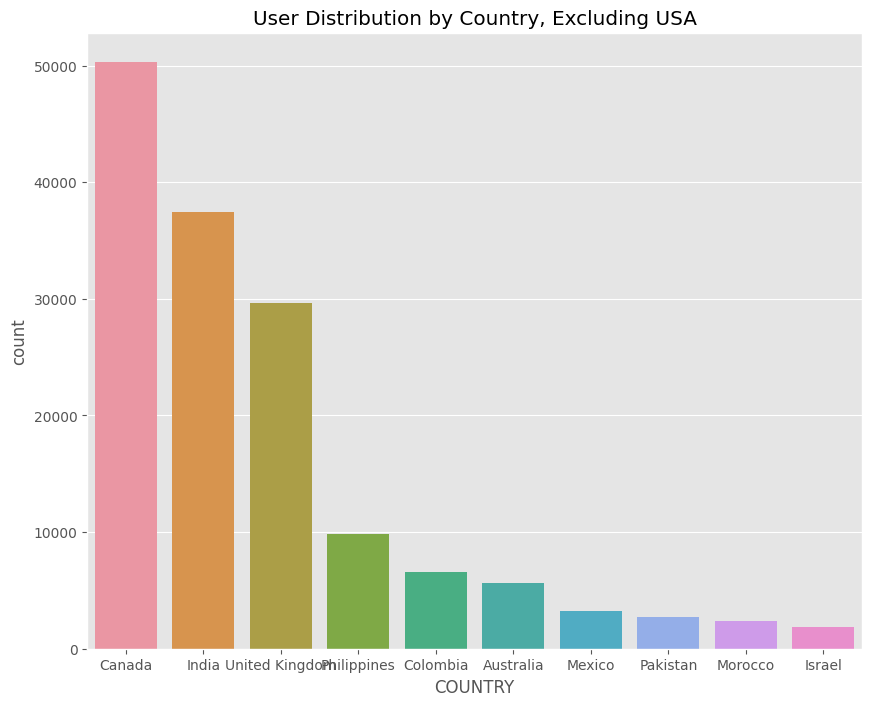

In [ ]:
#Country Distribution without the United States
plt.figure(figsize=(10,8))
plt.style.use("ggplot")
intl_data_no_us = intl_data[intl_data['COUNTRY'] != ('United States')]
sns.countplot(x=intl_data_no_us['COUNTRY'],order=intl_data_no_us['COUNTRY'].value_counts().head(10).index).set_title('User Distribution by Country, Excluding USA')

plt.savefig('User Distribution by Country, Excluding USA',)

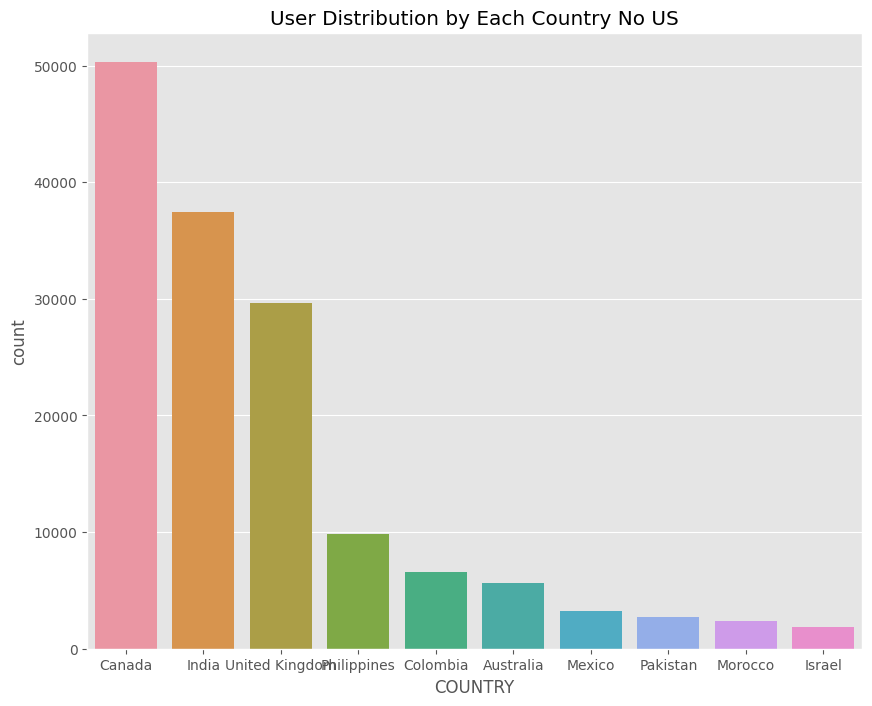

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Country Distribution without the United States
plt.figure(figsize=(10, 8))
plt.style.use("ggplot")
intl_data_no_us = intl_data[intl_data['COUNTRY'] != ('United States')]
sns.countplot(x=intl_data_no_us['COUNTRY'], order=intl_data_no_us['COUNTRY'].value_counts().head(10).index).set_title('User Distribution by Each Country No US')

# Save the chart data to a CSV file
chart_data = intl_data_no_us['COUNTRY'].value_counts().head(10).reset_index()
chart_data.columns = ['Country', 'Count']
chart_data.to_csv('country_distribution_no_us.csv', index=False)


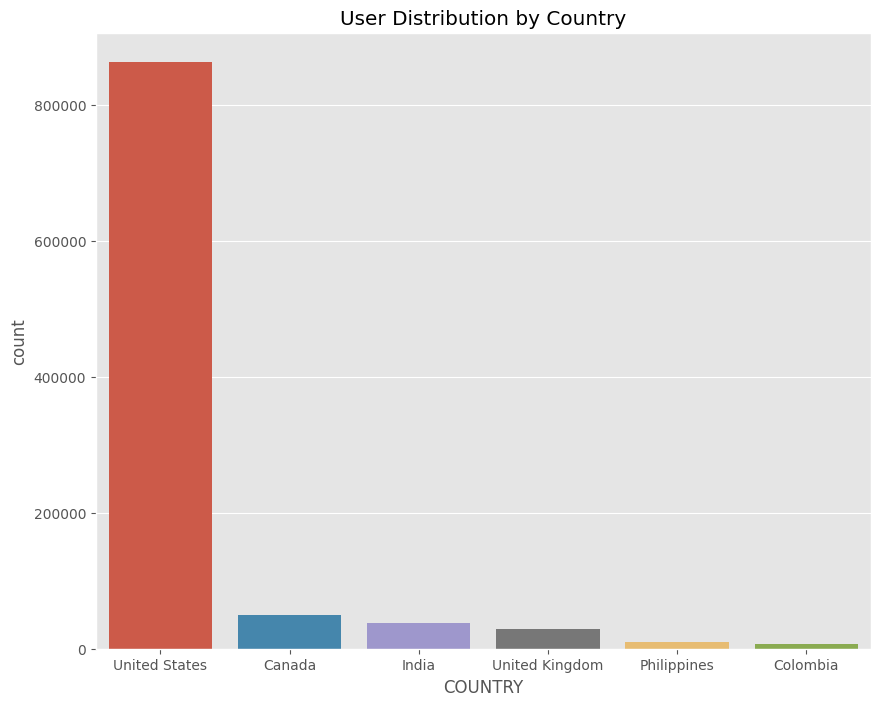

In [ ]:
#Country Distribution
plt.figure(figsize=(10,8))
plt.style.use("ggplot")
sns.countplot(x=intl_data['COUNTRY'],order=intl_data['COUNTRY'].value_counts().head(6).index).set_title('User Distribution by Country')
plt.savefig('User Distribution by Country',)

Text(0.5, 1.0, 'Distribution for Each Title')

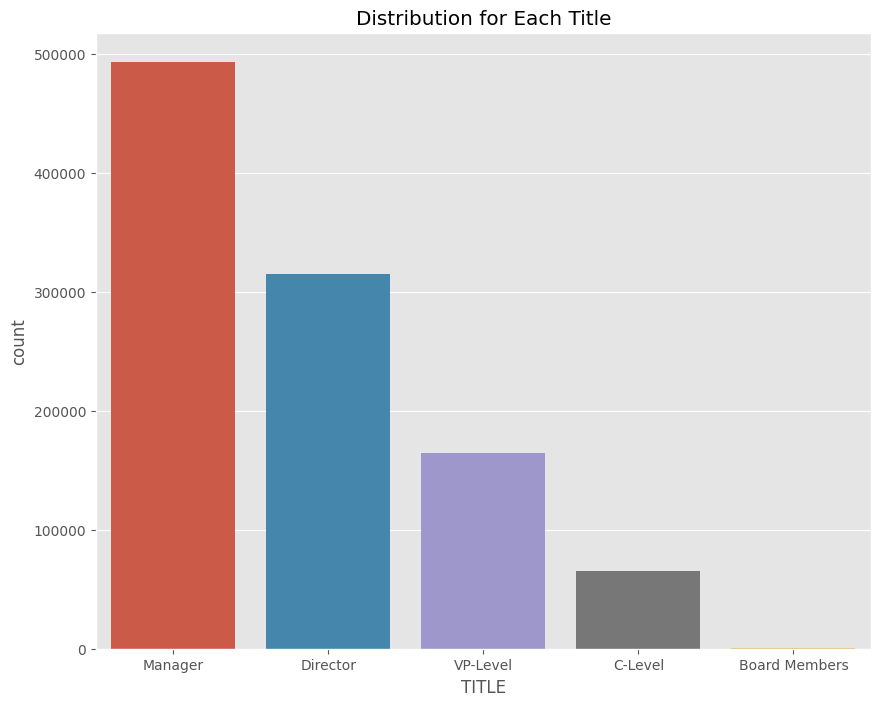

In [ ]:
#Title Distribution (also checking to make sure there are only managers and above)
plt.figure(figsize=(10,8))
sns.countplot(x=intl_data['TITLE'],order=intl_data['TITLE'].value_counts().index).set_title('Distribution for Each Title')

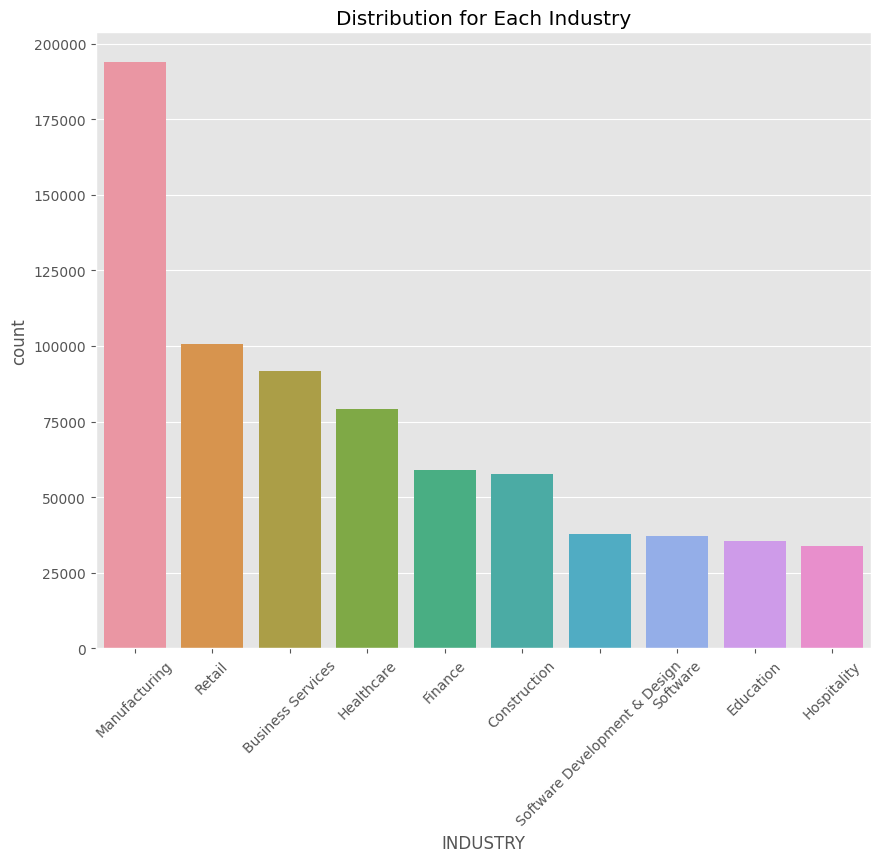

In [ ]:
#Industry Distribution
plt.figure(figsize=(10,8))
sns.countplot(x=intl_data['INDUSTRY'],order = intl_data['INDUSTRY'].value_counts().head(10).index).set_title('Distribution for Each Industry')
plt.xticks(rotation=45)
plt.savefig('Distribution_for_Each_Industry.png', dpi=300, format='png', bbox_inches='tight')

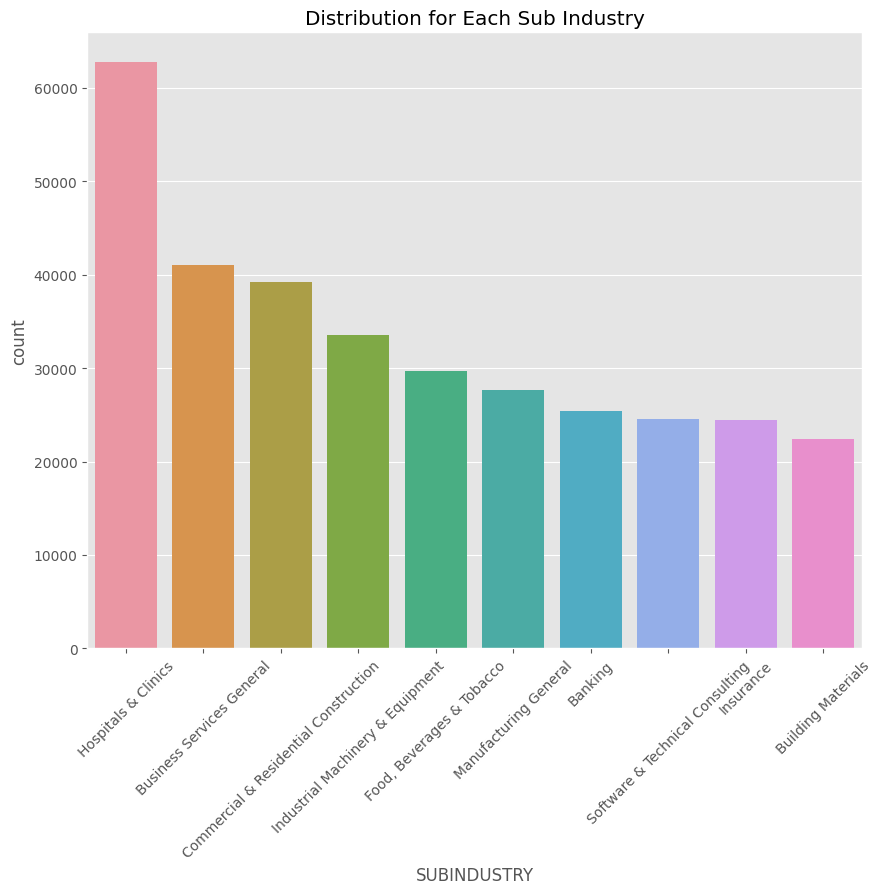

In [ ]:
#SUBIndustry Distribution
plt.figure(figsize=(10, 8))
sns.countplot(x=intl_data['SUBINDUSTRY'], order=intl_data['SUBINDUSTRY'].value_counts().head(10).index).set_title('Distribution for Each Sub Industry')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.savefig('Distribution_for_Each_Sub_Industry.png', dpi=300, format='png', bbox_inches='tight')


In [ ]:
plt.figure(figsize=(10,8))
plt.style.use("ggplot")
sns.countplot(x=intl_data['COUNTRY'],order=cluster['COUNTRY'].value_counts().head(10).index).set_title('Distribution of Top 10 Countries by Search Volume for All Segments')
plt.xticks(rotation=45)
plt.savefig('Distribution_of_Top_10_Countries_by_Search_Volume_for_All_Segments.png', dpi=300, format='png', bbox_inches='tight')

NameError: ignored

<Figure size 1000x800 with 0 Axes>

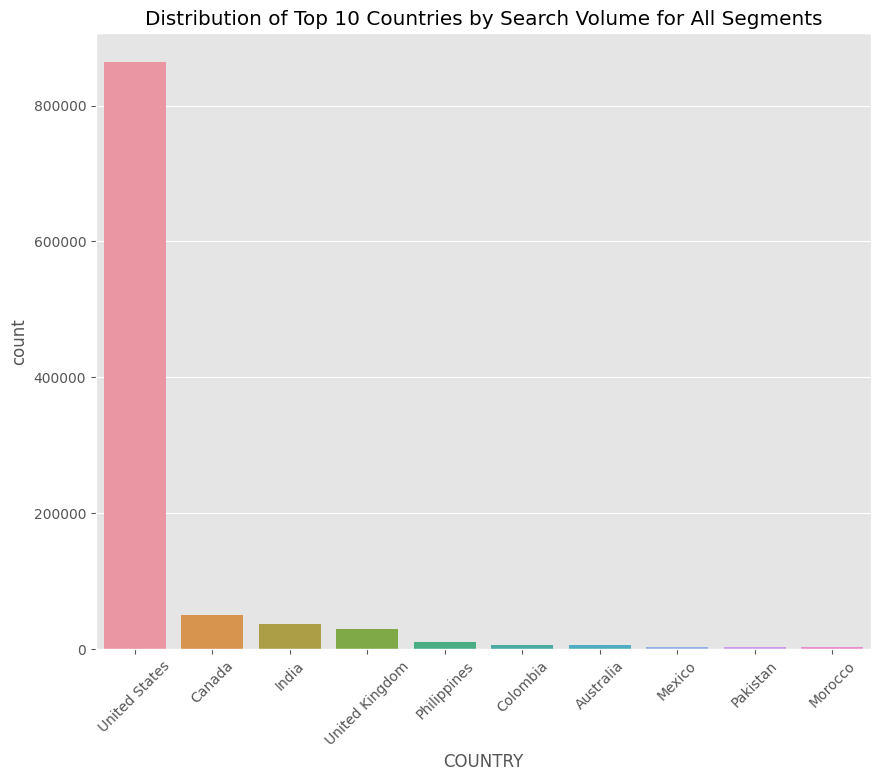

In [ ]:
plt.figure(figsize=(10,8))
plt.style.use("ggplot")
sns.countplot(x=intl_data['COUNTRY'],order=intl_data['COUNTRY'].value_counts().head(10).index).set_title('Distribution of Top 10 Countries by Search Volume for All Segments')
plt.xticks(rotation=45)
plt.savefig('Distribution_of_Top_10_Countries_by_Search_Volume_for_All_Segments.png', dpi=300, format='png', bbox_inches='tight')

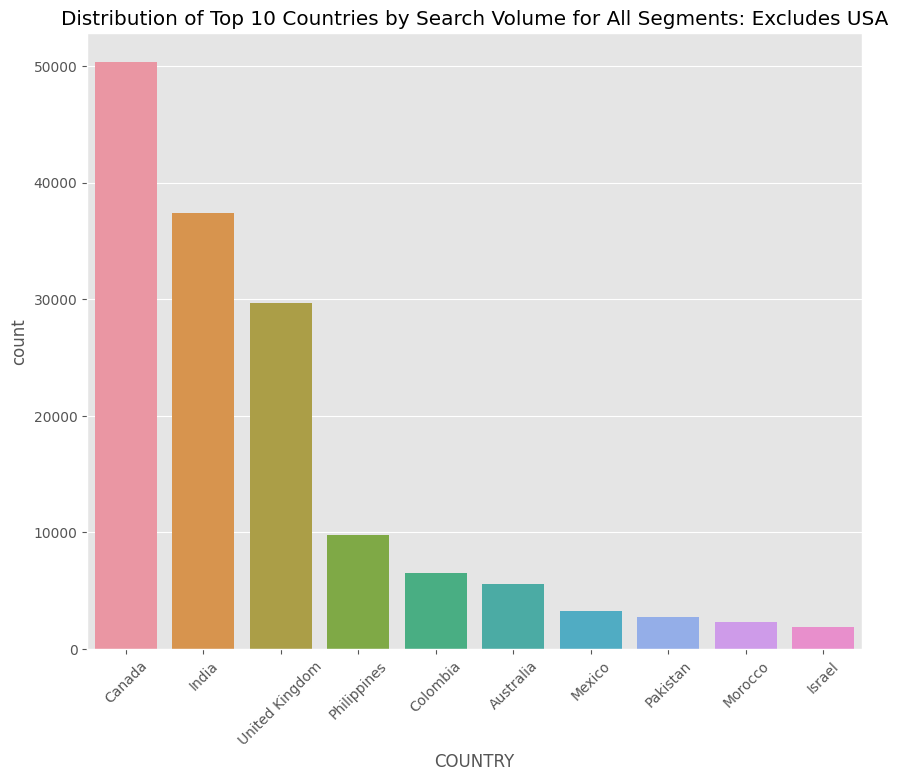

In [ ]:
plt.figure(figsize=(10,8))
plt.style.use("ggplot")
sns.countplot(x=intl_data_no_us['COUNTRY'],order=intl_data_no_us['COUNTRY'].value_counts().head(10).index).set_title('Distribution of Top 10 Countries by Search Volume for All Segments: Excludes USA')
plt.xticks(rotation=45)
plt.savefig('Distribution_of_Top_10_Countries_by_Search_Volume_for_All_Segments_Excludes_USA.png', dpi=300, format='png', bbox_inches='tight')

In [ ]:
#Dropping Categorical Variables Temporarily for Analysis
intl_data_attr = intl_data.drop(['ACCOUNTID','COUNTRY','INDUSTRY','SUBINDUSTRY','SEARCHED_MARKET_SEGMENT','CUSTOMER_STATUS','DEPARTMENT','TITLE'],axis = 1)

The graph below is a correlation heatmap. The closer a number is to 1 or -1 the more positively or negatively correlated it is.

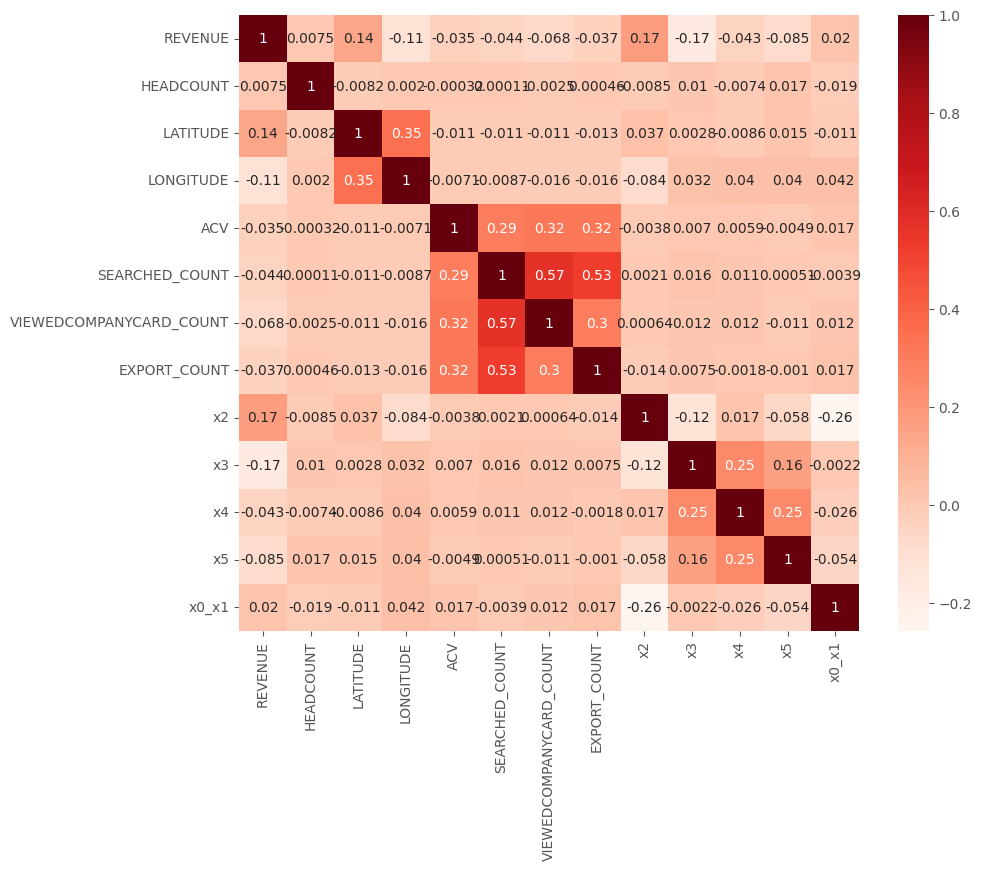

In [ ]:
#Heatmap correlation for the numerical columns
plt.figure(figsize=(10,8))
sns.heatmap(intl_data_attr.corr(),cmap=plt.cm.Reds,annot=True)
plt.show()

In [ ]:
#Machine Learning Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_df_kmeans = scaler.fit_transform(intl_data_attr)

The Scree Plot Below allows us to see how many components we need for the K-Means clustering. We need the number of components that can explain 80% of the variance in the data. So here it would be that many components.

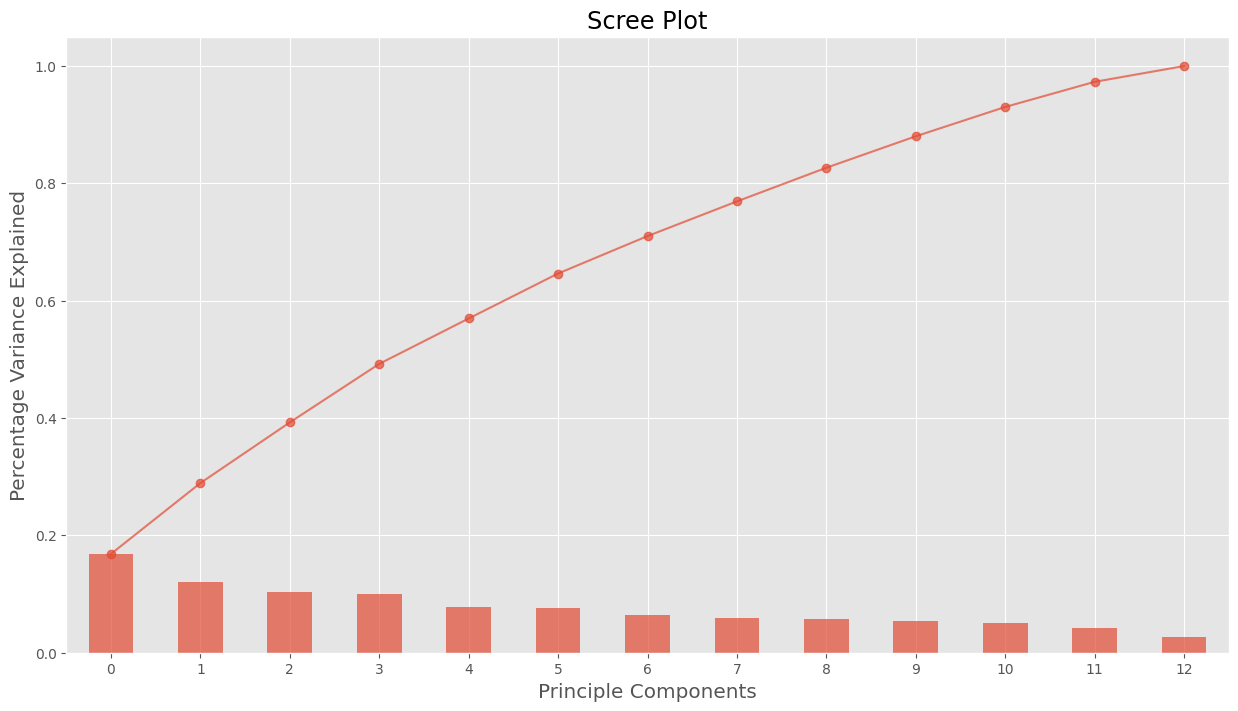

In [ ]:
#Performing principal component analysis to reduce dimensionality and get percentage variance explained. 7 components chosen.
pca = PCA()
pca.fit(scaled_df_kmeans)

sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_)
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)

pd.Series(var_ls).plot(marker="o", alpha=0.7) #plot line chart of increasing variances

plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Scree Plot", fontsize="xx-large")
plt.show();

scores_pca = pca.transform(scaled_df_kmeans)

In [ ]:
# create PCA with 9 components
pca = PCA(n_components=9)
scaled_df_kmeans = pca.fit_transform(scaled_df_kmeans)

With the plot below we can use what is called the "elbow method". Where the line curves from vertical to horizontal is the number of clusters we want to use. I eyeball about 15 clusters here.

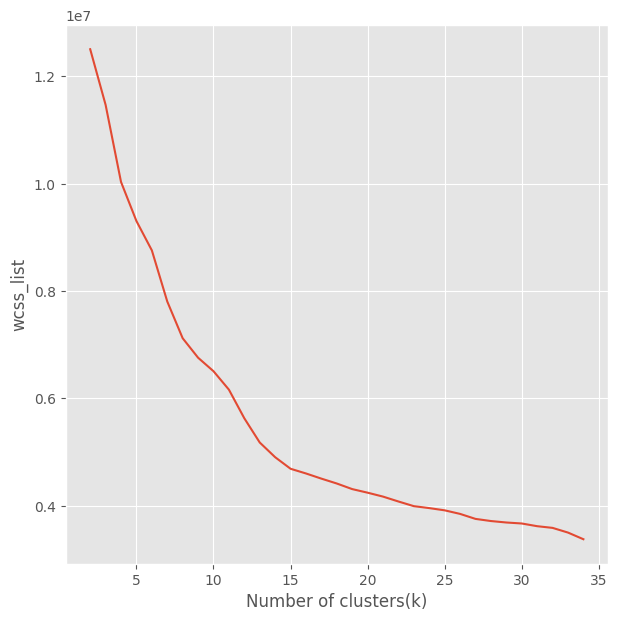

In [ ]:
#Finding an optimal number of clusters using the elbow method (about 15-20 clusters)
#This will take a bit to run
from sklearn.cluster import KMeans
wcss_list= []  #Initializing the list for the values of WCSS


for i in range(2, 35):
    kmeans = KMeans(n_clusters=i, random_state= 0, n_init = 'auto')
    kmeans.fit(scores_pca)
    wcss_list.append(kmeans.inertia_)

plt.figure(figsize=(7, 7))
plt.plot(range(2, 35), wcss_list)
plt.xlabel('Number of clusters(k)')
plt.ylabel('wcss_list')
plt.show()

# Clustering

Below is initializing the cluster model. kmeans_pca is the variable that is being assigned the name of the model.

In [ ]:
#Implementing with set number of clusters
num_clusters = 15
kmeans_pca = KMeans(n_clusters = num_clusters,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=15, random_state=42)

The code below appends the result of the kmeans model (cluster numbers) back to the intl_data variable with standardized values.

In [ ]:
#This code block adds the Segment K-means PCA column to allow us to determine which rows are part of each cluster.
segm_pca_kmeans = pd.concat([intl_data.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)

segm_pca_kmeans.insert(1, 'Segment K-means PCA', kmeans_pca.labels_)
segm_pca_kmeans

,ACCOUNTID,Segment K-means PCA,COUNTRY,SUBINDUSTRY,INDUSTRY,REVENUE,HEADCOUNT,SEARCHED_MARKET_SEGMENT,CUSTOMER_STATUS,LATITUDE,...,3,4,5,6,7,8,9,10,11,12
0,0011U00000aeCOEQA2,4,United States,Home Improvement & Hardware Retail,Retail,3644.0,8.0,SMB,Customer,26.035891,...,1.219856,0.200842,-0.040758,0.435517,17.210509,2.523859,0.256412,0.428011,4.042370,33.856256
1,0011U00000aeCOEQA2,4,United States,Commercial & Residential Construction,Construction,5599.0,15.0,SMB,Customer,33.660600,...,2.981808,0.251361,-0.208811,-0.094660,17.273385,1.626626,-0.061209,0.606933,2.433838,33.899523
2,0011U00000aeCOEQA2,4,United States,Software & Technical Consulting,Software,60533000.0,260000.0,ENT,Customer,41.109792,...,1.323056,-0.381514,0.927653,0.007839,17.467101,0.770434,-0.379215,0.352601,3.154154,33.874620
3,0011U00000aeCOEQA2,4,United States,Commercial & Residential Construction,Construction,5599.0,15.0,SMB,Customer,33.660600,...,2.981653,0.252178,-0.210049,-0.095022,17.303228,1.629302,-0.055928,0.605701,2.433356,33.895483
4,0011U00000aeCOEQA2,4,United States,"Department Stores, Shopping Centers & Superstores",Retail,538046000.0,1541000.0,ENT,Customer,47.622630,...,4.527517,-2.386584,3.590318,-0.795494,17.836541,0.305641,-0.617135,0.044575,3.114906,33.763707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037712,0011U00000add1NQAQ,7,United States,"Department Stores, Shopping Centers & Superstores",Retail,538046000.0,1541000.0,ENT,Former Customer,47.622630,...,2.286640,-2.205094,3.076703,-0.844340,0.217604,-1.091633,-0.424814,-0.528218,0.378835,-0.125216
1037713,0011U00000ae5hdQAA,0,United States,Advertising & Marketing,Business Services,345023.0,1000.0,MM,Customer,41.850789,...,-0.639982,-0.451596,0.411603,-1.586739,0.035027,-0.141708,0.095167,0.186423,-0.388842,-0.006911
1037714,0011U00000ae5hdQAA,7,United States,Computer Networking Equipment,Network Security Hardware & Software,387537000.0,164000.0,ENT,Customer,37.337359,...,0.948807,-1.245989,1.860891,0.263851,0.247435,-1.179813,-0.313419,0.932712,0.817166,-0.138224
1037715,0014y00002gcduKAAQ,7,United States,"Department Stores, Shopping Centers & Superstores",Retail,538046000.0,1541000.0,ENT,Customer,47.622630,...,2.286380,-2.203766,3.074694,-0.844916,0.266127,-1.087348,-0.416008,-0.530238,0.378038,-0.131626


In [ ]:
segm_pca_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037717 entries, 0 to 1037716
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ACCOUNTID                1037717 non-null  object 
 1   Segment K-means PCA      1037717 non-null  int32  
 2   COUNTRY                  1037717 non-null  object 
 3   SUBINDUSTRY              1030967 non-null  object 
 4   INDUSTRY                 1030967 non-null  object 
 5   REVENUE                  1037717 non-null  float64
 6   HEADCOUNT                1037717 non-null  float64
 7   SEARCHED_MARKET_SEGMENT  1037717 non-null  object 
 8   CUSTOMER_STATUS          1037717 non-null  object 
 9   LATITUDE                 1037717 non-null  float64
 10  LONGITUDE                1037717 non-null  float64
 11  DEPARTMENT               952335 non-null   object 
 12  TITLE                    1037717 non-null  object 
 13  ACV                      1037717 non-null 

In [ ]:
import pandas as pd

# Assuming your original DataFrame is named "segm_pca_kmeans"
# Group by 'accountId' and aggregate unique 'segmentNumber' values into a list
accountsBySegments = segm_pca_kmeans.groupby('ACCOUNTID')['Segment K-means PCA'].unique().reset_index()

# Rename the columns as per your requirement
accountsBySegments.columns = ['ACCOUNTID', 'Segment K-means PCA']

# Convert the list of unique segment numbers to a comma-separated string
accountsBySegments['Segment K-means PCA'] = accountsBySegments['Segment K-means PCA'].apply(lambda x: ', '.join(map(str, x)))
accountsBySegments
accountsBySegments.to_csv('accountsBySegments.csv')
# If you want to ensure that 'Segment K-means PCA' is a string, you can add this line:
# accountsBySegments['Segment K-means PCA'] = accountsBySegments['Segment K-means PCA'].astype(str)

# Now, accountsBySegments contains the desired DataFrame with distinct values in "Segment K-means PCA"



Average Revenue Per Cluster: Self-explanatory, the code iterates over each cluster and averages the revenue within the cluster.

In [ ]:
#Average revenue per segment
llist = []

for i in range(0,num_clusters):
  df = segm_pca_kmeans.loc[segm_pca_kmeans['Segment K-means PCA'] == i]
  llist.append([df['ACV'].mean()])

llist

[[126452.82924057025],
 [126704.18089853431],
 [110629.76985017015],
 [134330.71127115685],
 [354923.1346276595],
 [112423.40686667037],
 [367052.92616563325],
 [106278.889881632],
 [128574.90929628236],
 [296783.3947474038],
 [3334355.0229537985],
 [130242.03264315885],
 [171909.8175],
 [119544.19319718794],
 [132629.2765139088]]

Plot of the average ACV for each cluster.

Text(0.5, 1.0, 'Average ACV per Cluster')

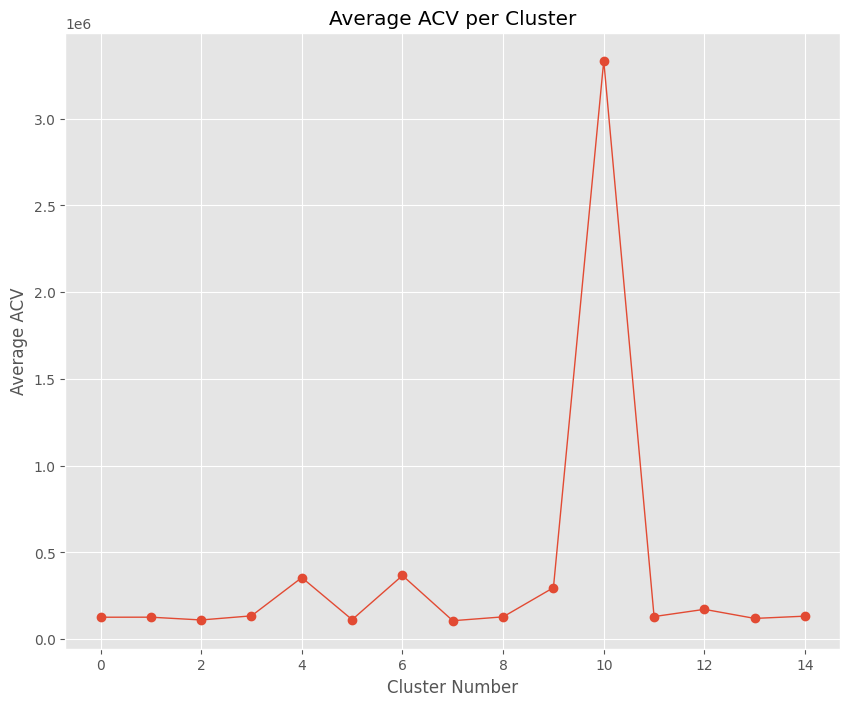

In [ ]:
#Plotting Average Revenue, ACV, and Headcount
plt.figure(figsize=(10,8))
plt.plot(llist,marker='o',linewidth=1)
plt.xlabel('Cluster Number')
plt.ylabel('Average ACV')
plt.title('Average ACV per Cluster')

The code below does a few steps:

1. It iterates over each cluster number
2. Calculate the average ACV for a cluster similar to the code above but with no duplicate ACV values from the same accountID/GroupID
3. The total ACV for the cluster
4. The number of Salesforce (SF) Accounts in the cluster

Dropping duplicates is important so that duplicate accounts are not counted.

In [ ]:
for i in range(0,num_clusters):
  df = segm_pca_kmeans.loc[segm_pca_kmeans['Segment K-means PCA'] == i]
  segment = df.drop_duplicates(subset = "ACCOUNTID")
  print('The average ACV for cluster', i, 'is', '${:,.0f}'.format(np.average(segment['ACV'])))
  print('The total ACV for cluster ', i, 'is', '${:,.0f}'.format(np.sum(segment['ACV'])))
  print('The number of accounts for cluster ', i, 'is', np.sum(len(pd.unique(df['ACCOUNTID']))))
  print('')

The average ACV for cluster 0 is $72,500
The total ACV for cluster  0 is $372,431,200
The number of accounts for cluster  0 is 5137

The average ACV for cluster 1 is $70,315
The total ACV for cluster  1 is $424,140,654
The number of accounts for cluster  1 is 6032

The average ACV for cluster 2 is $69,649
The total ACV for cluster  2 is $423,606,794
The number of accounts for cluster  2 is 6082

The average ACV for cluster 3 is $73,655
The total ACV for cluster  3 is $354,870,809
The number of accounts for cluster  3 is 4818

The average ACV for cluster 4 is $411,314
The total ACV for cluster  4 is $1,233,942
The number of accounts for cluster  4 is 3

The average ACV for cluster 5 is $77,043
The total ACV for cluster  5 is $323,736,767
The number of accounts for cluster  5 is 4202

The average ACV for cluster 6 is $570,083
The total ACV for cluster  6 is $3,420,498
The number of accounts for cluster  6 is 6

The average ACV for cluster 7 is $69,987
The total ACV for cluster  7 is $428

The code below calculates the percentage of searches a segment has within all the data as well as the number of absolute searches within a cluster.

In [ ]:
#Use this to calculate the percentage of searches that are in a cluster
for i in range(0,num_clusters):
  df = segm_pca_kmeans.loc[segm_pca_kmeans['Segment K-means PCA'] == i]
  print('The percentage of searches in cluster ', i, 'is', '{:,.2f}'.format(sum(df['SEARCHED_COUNT'])/sum(segm_pca_kmeans['SEARCHED_COUNT'])*100))
  print('The number of searches for cluster ', i, 'is', np.sum((pd.unique(df['SEARCHED_COUNT']))))
  print('')


The percentage of searches in cluster  0 is 5.50
The number of searches for cluster  0 is 113750003

The percentage of searches in cluster  1 is 7.33
The number of searches for cluster  1 is 120322466

The percentage of searches in cluster  2 is 7.48
The number of searches for cluster  2 is 119738718

The percentage of searches in cluster  3 is 4.70
The number of searches for cluster  3 is 115901202

The percentage of searches in cluster  4 is 8.42
The number of searches for cluster  4 is 17581087

The percentage of searches in cluster  5 is 2.22
The number of searches for cluster  5 is 112516840

The percentage of searches in cluster  6 is 14.30
The number of searches for cluster  6 is 7521956

The percentage of searches in cluster  7 is 2.01
The number of searches for cluster  7 is 131473992

The percentage of searches in cluster  8 is 3.66
The number of searches for cluster  8 is 112259571

The percentage of searches in cluster  9 is 22.34
The number of searches for cluster  9 is 28

In [ ]:
#Use this to calculate the percentage of views that are in a cluster
for i in range(0,num_clusters):
  df = segm_pca_kmeans.loc[segm_pca_kmeans['Segment K-means PCA'] == i]
  print('The percentage of views in cluster ', i, 'is', '{:,.2f}'.format(sum(df['VIEWEDCOMPANYCARD_COUNT'])/sum(segm_pca_kmeans['VIEWEDCOMPANYCARD_COUNT'])*100))
  print('The number of view for cluster ', i, 'is', np.sum((pd.unique(df['VIEWEDCOMPANYCARD_COUNT']))))
  print('')

The percentage of views in cluster  0 is 4.58
The number of view for cluster  0 is 122273791

The percentage of views in cluster  1 is 5.87
The number of view for cluster  1 is 131473849

The percentage of views in cluster  2 is 5.76
The number of view for cluster  2 is 129638778

The percentage of views in cluster  3 is 3.80
The number of view for cluster  3 is 123766376

The percentage of views in cluster  4 is 3.37
The number of view for cluster  4 is 2860907

The percentage of views in cluster  5 is 1.48
The number of view for cluster  5 is 120359359

The percentage of views in cluster  6 is 36.74
The number of view for cluster  6 is 13065580

The percentage of views in cluster  7 is 1.47
The number of view for cluster  7 is 140190490

The percentage of views in cluster  8 is 2.95
The number of view for cluster  8 is 120555670

The percentage of views in cluster  9 is 15.66
The number of view for cluster  9 is 31259283

The percentage of views in cluster  10 is 3.61
The number of v

The code below calculates the percentage of exports a segment has within all the data as well as the number of absolute exports within a cluster.

In [ ]:
#Use this to calculate the percentage of exports that are in a cluster
for i in range(0,num_clusters):
  df = segm_pca_kmeans.loc[segm_pca_kmeans['Segment K-means PCA'] == i]
  print('The percentage of exports in cluster ', i, 'is', '{:,.2f}'.format(sum(df['EXPORT_COUNT'])/sum(segm_pca_kmeans['EXPORT_COUNT'])*100))
  print('The number of exports for cluster ', i, 'is', np.sum((pd.unique(df['EXPORT_COUNT']))))
  print('')

The percentage of exports in cluster  0 is 5.93
The number of exports for cluster  0 is 24178738

The percentage of exports in cluster  1 is 9.27
The number of exports for cluster  1 is 26560526

The percentage of exports in cluster  2 is 8.28
The number of exports for cluster  2 is 26223967

The percentage of exports in cluster  3 is 4.71
The number of exports for cluster  3 is 23655117

The percentage of exports in cluster  4 is 20.07
The number of exports for cluster  4 is 1281297

The percentage of exports in cluster  5 is 2.00
The number of exports for cluster  5 is 22657871

The percentage of exports in cluster  6 is 3.84
The number of exports for cluster  6 is 217055

The percentage of exports in cluster  7 is 1.79
The number of exports for cluster  7 is 27395837

The percentage of exports in cluster  8 is 3.72
The number of exports for cluster  8 is 22757713

The percentage of exports in cluster  9 is 12.90
The number of exports for cluster  9 is 3840590

The percentage of expo

To view distributions and map locations of clusters the last 4 code blocks can help.

!. The first block selects what cluster number is being isolated
2. The second code block shows the locations of companies users are searching for
3 + 4: The distribution for industry and country within that particular cluster.

In [ ]:
#The cluster being focused on
#cluster = segm_pca_kmeans.loc[(segm_pca_kmeans['Segment K-means PCA'] == 14)] #Replace the number with the cluster number
cluster = segm_pca_kmeans

<ipython-input-42-2a042b553ce2>:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 1.0, 'Locations of Companies Being Searched')

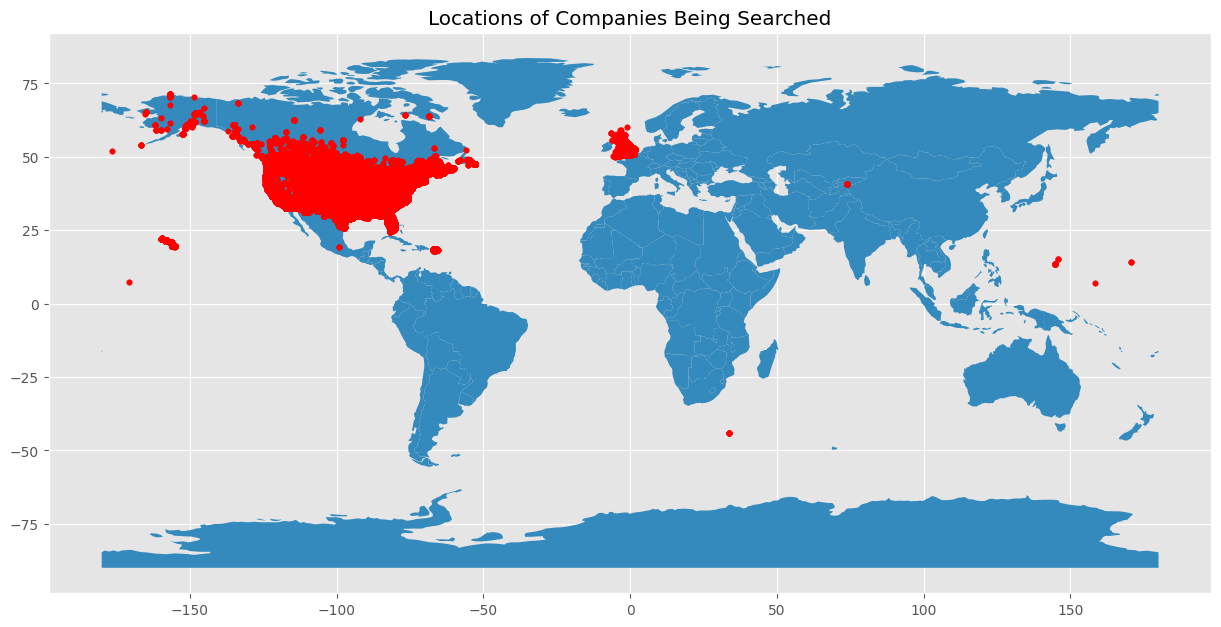

In [ ]:
#The graph below displays where users are searching using the Company table latitude and longitude values.
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

##cluster = cluster.drop(cluster[cluster.countryd == 'United States'].index)
geometry = [Point(xy) for xy in zip(cluster['LONGITUDE'], cluster['LATITUDE'])]
gdf = GeoDataFrame(cluster, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 12)), marker='o', color='red', markersize=15)
plt.title('Locations of Companies Being Searched')

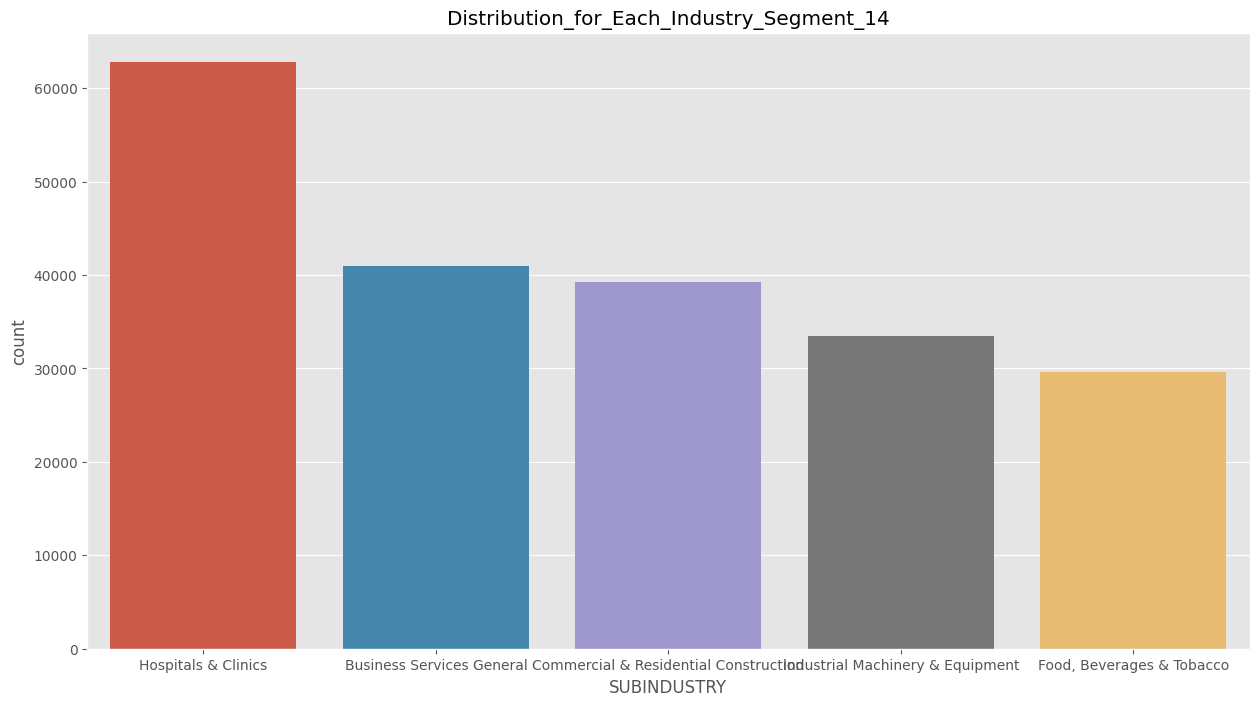

In [ ]:
#Distribution of industry within a cluster
plt.figure(figsize=(15,8))
sns.countplot(x=cluster['SUBINDUSTRY'],order = cluster['SUBINDUSTRY'].value_counts().head(5).index).set_title('Distribution_for_Each_Industry_Segment_14')
plt.xticks(rotation=0)
plt.savefig('Distribution_for_Each_Industry_Segment_14.png', dpi=300, format='png', bbox_inches='tight')

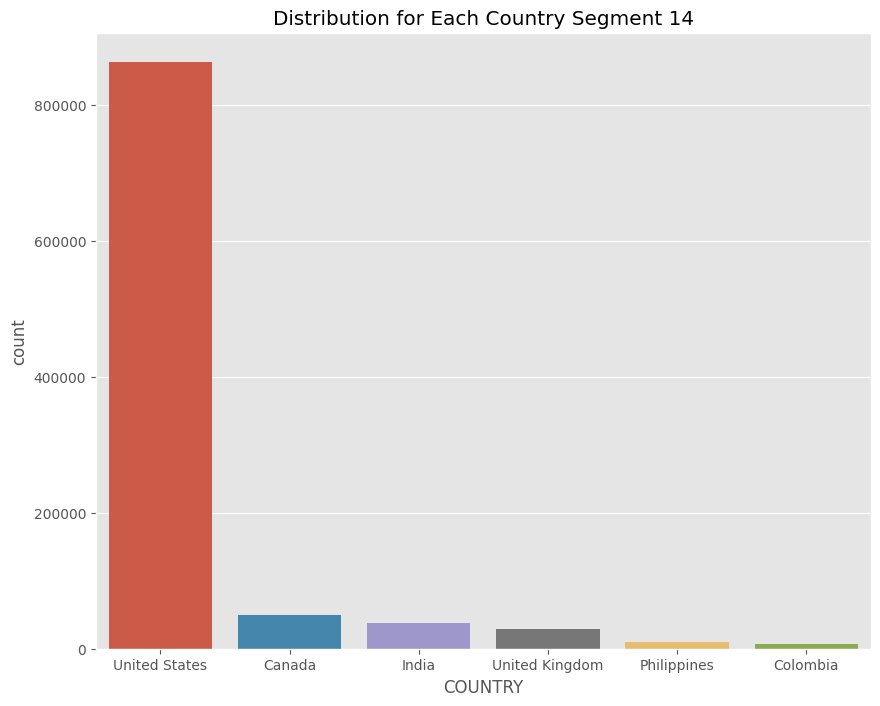

In [ ]:
#The distribution of countries that are searching
plt.figure(figsize=(10,8))
plt.style.use("ggplot")
sns.countplot(x=cluster['COUNTRY'],order=cluster['COUNTRY'].value_counts().head(6).index).set_title('Distribution for Each Country Segment 14')
plt.xticks(rotation=0)
plt.savefig('Distribution_for_Each_Country_Segment_14.png', dpi=300, format='png', bbox_inches='tight')


In [ ]:
cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037717 entries, 0 to 1037716
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ACCOUNTID                1037717 non-null  object 
 1   Segment K-means PCA      1037717 non-null  int32  
 2   COUNTRY                  1037717 non-null  object 
 3   SUBINDUSTRY              1030967 non-null  object 
 4   INDUSTRY                 1030967 non-null  object 
 5   REVENUE                  1037717 non-null  float64
 6   HEADCOUNT                1037717 non-null  float64
 7   SEARCHED_MARKET_SEGMENT  1037717 non-null  object 
 8   CUSTOMER_STATUS          1037717 non-null  object 
 9   LATITUDE                 1037717 non-null  float64
 10  LONGITUDE                1037717 non-null  float64
 11  DEPARTMENT               952335 non-null   object 
 12  TITLE                    1037717 non-null  object 
 13  ACV                      1037717 non-null 

In [ ]:
import pandas as pd

# Assuming you have a DataFrame called segm_pca_kmeans

# Filter the records that have "Segment PCA K-Means" values of 11, 7, 5, 13, 1
selected_pca_values = [11, 7, 5, 13, 1]
filtered_data = segm_pca_kmeans[segm_pca_kmeans['Segment K-means PCA'].isin(selected_pca_values)]

# Group by the specified columns and perform aggregation
result_df = filtered_data.groupby(['COUNTRY','INDUSTRY', 'SUBINDUSTRY', 'MARKET_SEGMENT', 'CUSTOMER_STATUS']).agg({'ACV': 'sum', 'ACCOUNTID': 'count'}).reset_index()

# Rename the columns
result_df.columns = ['Country','Industry', 'SubIndustry', 'Market Segment', 'Customer Status', 'Sum of ACV', 'Count of ACCOUNTID']

# Display the resulting DataFrame
print(result_df)
result_df.to_csv("result_df2.csv")

      Country                             Industry  \
0     Albania  Energy, Utilities & Waste Treatment   
1     Albania                              Finance   
2     Albania                              Finance   
3     Albania                              Finance   
4     Albania                          Hospitality   
...       ...                                  ...   
8927  Vietnam                               Retail   
8928  Vietnam                             Software   
8929  Vietnam        Software Development & Design   
8930  Vietnam                   Telecommunications   
8931  Vietnam                       Transportation   

                           SubIndustry Market Segment Customer Status  \
0              Water & Water Treatment            ENT        Customer   
1                              Banking            ENT        Customer   
2                              Banking             MM        Customer   
3                   Investment Banking             MM      

In [ ]:
import pandas as pd

# Assuming you have a DataFrame called 'segm_pca_kmeans'
# Group by the specified columns and sum 'SEARCHED_COUNT' and 'EXPORT_COUNT'
industry_counts = segm_pca_kmeans.groupby(['INDUSTRY', 'SUBINDUSTRY', 'SEARCHED_MARKET_SEGMENT', 'LATITUDE', 'LONGITUDE'])[['SEARCHED_COUNT', 'EXPORT_COUNT']].sum().reset_index()

# Rename the columns as needed
industry_counts.columns = ['INDUSTRY', 'SUBINDUSTRY', 'SEARCHED_MARKET_SEGMENT', 'LATITUDE', 'LONGITUDE', 'SUM_SEARCHED_COUNT', 'SUM_EXPORT_COUNT']

# Assign the result to a new DataFrame called 'INDUSTRY_COUNTS'
INDUSTRY_COUNTS = industry_counts
print(INDUSTRY_COUNTS)
INDUSTRY_COUNTS.to_csv('INDUSTRY_COUNTS.csv')


              INDUSTRY                 SUBINDUSTRY SEARCHED_MARKET_SEGMENT  \
0          Agriculture                 Agriculture                     ENT   
1          Agriculture                 Agriculture                     ENT   
2          Agriculture                 Agriculture                      MM   
3          Agriculture                 Agriculture                      MM   
4          Agriculture                 Agriculture                      MM   
...                ...                         ...                     ...   
292903  Transportation  Trucking, Moving & Storage                     SMB   
292904  Transportation  Trucking, Moving & Storage                     SMB   
292905  Transportation  Trucking, Moving & Storage                     SMB   
292906  Transportation  Trucking, Moving & Storage                     SMB   
292907  Transportation  Trucking, Moving & Storage                     SMB   

         LATITUDE   LONGITUDE  SUM_SEARCHED_COUNT  SUM_EXPORT_C

In [ ]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

# Create a geocoder
geolocator = Nominatim(user_agent="country_locator")

# Function to get the country name based on latitude and longitude with retries
def get_country_name(lat, lon, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.reverse((lat, lon))
            if location and 'address' in location.raw:
                return location.raw['address'].get('country', 'Unknown')
            else:
                return 'Unknown'
        except GeocoderTimedOut:
            # Handle timeouts by waiting for a moment and then retrying
            time.sleep(1)
            retries += 1
    return 'Unknown'

# Apply the function to create a new 'SEARCHED_COUNTRY' column in the DataFrame
industry_counts['SEARCHED_COUNTRY'] = industry_counts.apply(lambda row: get_country_name(row['LATITUDE'], row['LONGITUDE']), axis=1)

# Display the updated DataFrame
print(industry_counts)



GeocoderUnavailable: ignored